## Imports ##

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import math
import datetime
from numpy import linalg


from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

# Models
from surprise import KNNBaseline, BaselineOnly
from surprise import SVD, SVDpp, NMF, SlopeOne, CoClustering


from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import Reader
import matplotlib.pyplot as plt
import pickle

In [235]:
def plot(errors, names=[]):
    
    for error in errors:
        x, y = zip(*error)    
        plt.plot(np.array(x), np.array(y), 'o-')
    
    plt.legend(names, loc='upper left')
    plt.ylabel('RMSE')
    plt.xlabel('n factors')

    plt.show()
    

def save(liste, name="errors"):
    with open(name, 'wb') as fp:
        pickle.dump(liste, fp)

def read(name="errors"):
    with open (name, 'rb') as fp:
        return pickle.load(fp)
    
def create_submission(algo):
    data = Dataset.load_from_df(df[['people', 'movies', 'Prediction']], reader)
    trainset = data.build_full_trainset()
    algo.fit(trainset)
    submission = toPredict[['people', 'movies', 'Prediction']].values.tolist()
    submission_pred = algo.test(submission)
    data = {'Id': ['r' + str(submission_pred[0].iid) + '_c' + str(submission_pred[0].uid)], 'Prediction': [str(submission_pred[0].est)]}
    for i in range(1, len(submission_pred)):
        data['Id'].append('r{0}_c{1}'.format(movies[i], peoples[i]))
        data['Prediction'].append(str(submission_pred[i].est))
    
    submission_df = pd.DataFrame(data).rename(columns={0 : 'Id', 1 : 'Prediction'})    
    submission_df.Prediction = [round(float(val)) for val in submission_df.Prediction.values]
    submission_df.to_csv(relative_path + '/submission.csv')

## Importing and formating ##

In [67]:
relative_path = os.getcwd() + "/data"

df = pd.read_csv(relative_path + '/data_train.csv').set_index("Id")
movies, people = zip(*[tuple(int(x[1:]) for x in x.split("_")) for x in df.index.values])
df["movies"] = movies
df["people"] = people
df = df.reset_index().drop(columns=["Id"])

predictions = pd.read_csv(relative_path + '/sample_submission.csv').set_index("Id")
toPredict = predictions.copy()
movies, people = zip(*[tuple(int(x[1:]) for x in x.split("_")) for x in toPredict.index.values])
toPredict["movies"] = movies
toPredict["people"] = people
toPredict = toPredict.reset_index().drop(columns=["Id"])

# Initializing Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['people', 'movies', 'Prediction']], reader)

In [68]:
# Nombre moyen de movies par people
tmp = df.groupby(df.people).count()
res = sum(tmp.movies.values)/tmp.count()[0]
print("En moyenne, on a {} movies per people".format(res))

# Nombre moyen de movies par people
tmp = df.groupby(df.movies).count()
res = sum(tmp.people.values)/tmp.count()[0]
print("En moyenne, on a {} people per movie".format(res))

print("{0} movies and {1} users".format(len(df.movies.unique()), len(df.people.unique()))) 

En moyenne, on a 1176.952 movies per people
En moyenne, on a 117.6952 people per movie
10000 movies and 1000 users


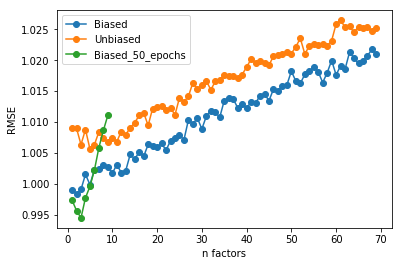

In [25]:
names = ["Biased", "Unbiased", "Biased_50_epochs"]
errors = [read("tmp/"+name) for name in names]
plot(errors, names)

## Grid Search on every model

In [113]:
SVD_param_grid = {'n_epochs': [400, 600],
                  'n_factors': [60],
                  'lr_all': [0.0018, 0.0014, 0.001],
                  'reg_all': [0.1]}

NMF_param_grid = {'n_epochs': [100, 150],  
                  'n_factors': [10, 15, 20]}

KNNBaseline_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [30, 50, 70],
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False, True]}
              }

CoClustering_param_grid = {'n_cltr_u': [3, 4, 5],  
                  'n_cltr_i': [3, 4, 5], 
                 'n_epochs': [25, 50, 100]}


models = [(SVD, SVD_param_grid), (NMF, NMF_param_grid), (SlopeOne, {}), 
           (KNNBaseline, KNNBaseline_param_grid), (CoClustering, CoClustering_param_grid)]

In [114]:
all_dfs = []

for (algo, param_grid) in models:
    
    print("Testing {}".format(algo))
    gs = GridSearchCV(algo, param_grid, measures=['rmse'], cv=5, joblib_verbose=4, n_jobs=-1)
    gs.fit(data)

    # best RMSE score
    print(gs.best_score['rmse'])

    # combination of parameters that gave the best RMSE score
    print(gs.best_params['rmse'])
    
    # Saving all data into a df
    results_df = pd.DataFrame.from_dict(gs.cv_results)
    results_df.to_csv("GRID_SEARCH_{}12".format(algo))
    all_dfs.append((algo, results_df))

Testing <class 'surprise.prediction_algorithms.matrix_factorization.SVD'>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 80.1min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 150.7min remaining: 45.9min


0.9849581670928996
{'n_epochs': 400, 'n_factors': 60, 'lr_all': 0.0018, 'reg_all': 0.1}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 201.2min finished


In [ ]:
def create_best_svd():
    algo = SVD(n_epochs=1, n_factors=60, lr_all=0.005, reg_all=0.1, verbose=True)
    create_submission(algo)

### Neural Netowork

In [346]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import keras
from IPython.display import SVG
from keras.optimizers import Adam
# from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import mean_absolute_error
from keras.regularizers import l2
from keras.models import model_from_json

In [216]:
relative_path = os.getcwd() + "/data"

dataset = pd.read_csv(relative_path + '/data_train.csv').set_index("Id")
movies, people = zip(*[tuple(int(x[1:]) for x in x.split("_")) for x in dataset.index.values])
dataset["item_id"] = movies
dataset["user_id"] = people
dataset = dataset.reset_index().drop(columns=["Id"]).rename(columns={"Prediction":"rating"})

10000 movies and 1000 users


,rating,item_id,user_id
0,4,44,1
1,3,61,1
2,4,67,1
3,3,72,1
4,5,86,1


In [409]:
# Create submission file given a trained model
def submission_nn(model):
    submission = toPredict[['people', 'movies', 'Prediction']].values.tolist()
    peoples, movies, _ = list(map(list, zip(*submission)))

    grades = [max(min(c[0], 5), 1) for c in np.round(model.predict([peoples, movies]),0)]

    data = {'Id': [], 'Prediction': []}
    for i in range(len(grades)):
        data['Id'].append('r{0}_c{1}'.format(movies[i], peoples[i]))
        data['Prediction'].append(str(grades[i]))

    submission_df = pd.DataFrame(data).rename(columns={0 : 'Id', 1 : 'Prediction'}).set_index("Id")    
    submission_df.Prediction = [round(float(val)) for val in submission_df.Prediction.values]
    submission_df.to_csv(relative_path + '/submission.csv')
    return submission_df

# Simple network
def dot_product_network(dropout=0.5):
    # Matrix factorisation in Keras
    n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
    
    features = int(60*(1 + dropout))
    
    # Creating movie input
    movie_input = keras.layers.Input(shape=[1],name='Item')
    
    movie_embedding = keras.layers.Embedding(n_movies + 1, features, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    movie_drop = keras.layers.Dropout(dropout)(movie_vec)

    # Creating user input
    user_input = keras.layers.Input(shape=[1],name='User')
    user_embedding = keras.layers.Embedding(n_users + 1, features, name='User-Embedding')(user_input)
    user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
    user_drop = keras.layers.Dropout(dropout)(user_vec)

    # Merging
    prod = keras.layers.Dot(axes=1)([movie_drop, user_drop])

    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

# More complex network (allowing non-linear combining of features vectors)
def concat_network(dropout=0.3):
    n_latent_factors_user = int(60*(1+dropout))
    n_latent_factors_movie = int(60*(1+dropout))

    n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())

    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    movie_vec = keras.layers.Dropout(dropout)(movie_vec)


    user_input = keras.layers.Input(shape=[1],name='User')
    user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input)
    user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
    user_vec = keras.layers.Dropout(dropout)(user_vec)

    concat = keras.layers.Concatenate()([movie_vec, user_vec])
    dense = keras.layers.Dense(200,name='FullyConnected')(concat)
    dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
    dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dropout_1)


    result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
    adam = Adam(lr=0.005)
    model = keras.Model([user_input, movie_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')

    return model


# Plot learning curves
def plot_history(name): 
    history = read(name)
    pd.Series(history['loss']).plot(logy=True)
    ax = pd.Series(history['val_loss']).plot(logy=True)
    ax.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel("Epoch")
    plt.ylabel("Train Error")
    plt.plot()
    
def test_model(df, model):
    y_hat = [max(min(c[0], 5), 1) for c in np.round(model.predict([df.user_id, df.item_id]),0)]
    y_true = df.rating
    print("MAE: {}".format(mean_absolute_error(y_true, y_hat)))

def save_model(model, name):
    model_json = model.to_json()
    with open("{}.json".format(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("{}.h5".format(name))
    
    
def read_model(name): 
    json_file = open('{}.json'.format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("{}.h5".format(name))
    return loaded_model

def create_best_nn():
    model = concat_network()
    model.fit([dataset.user_id, dataset.item_id], dataset.rating, epochs=30, verbose=1)
    submission_nn(model)

#### Grid Search

In [363]:
# X = dataset.user_id, dataset.item_id
Y = dataset.rating

results = {}

train, test = train_test_split(dataset, test_size=0.2)
x_train = [train.user_id, train.item_id]
y_train = train.rating

x_test = [test.user_id, test.item_id]
y_test = test.rating

# for l2_param in np.linspace(0.005, 0.02, 3):
for dropout in np.linspace(0.3, 0.5, 3):

    # Create model
    model = dot_product_network(dropout=dropout)

    # Fit the model
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=40, verbose=1)
    save(history.history, "nn/history:{0}".format(params))
    save_model(model, "nn/{0}".format(params))

Train on 941561 samples, validate on 235391 samples
Epoch 1/40
941561/941561 [==============================] - 152s 161us/step - loss: 3.7480 - val_loss: 1.1527
Epoch 2/40
941561/941561 [==============================] - 155s 165us/step - loss: 1.4475 - val_loss: 1.1374
Epoch 3/40
941561/941561 [==============================] - 159s 169us/step - loss: 1.4195 - val_loss: 1.1215
Epoch 4/40
941561/941561 [==============================] - 165s 175us/step - loss: 1.3979 - val_loss: 1.1163
Epoch 5/40
941561/941561 [==============================] - 177s 188us/step - loss: 1.3851 - val_loss: 1.1090
Epoch 6/40
941561/941561 [==============================] - 168s 178us/step - loss: 1.3768 - val_loss: 1.1017
Epoch 7/40
941561/941561 [==============================] - 180s 191us/step - loss: 1.3698 - val_loss: 1.1039
Epoch 8/40
941561/941561 [==============================] - 178s 189us/step - loss: 1.3672 - val_loss: 1.0974
Epoch 9/40
941561/941561 [==============================] - 181s 193

Epoch 34/40
941561/941561 [==============================] - 166s 176us/step - loss: 1.6418 - val_loss: 1.1167
Epoch 35/40
941561/941561 [==============================] - 159s 169us/step - loss: 1.6435 - val_loss: 1.1203
Epoch 36/40
941561/941561 [==============================] - 159s 169us/step - loss: 1.6483 - val_loss: 1.1229
Epoch 37/40
941561/941561 [==============================] - 343s 364us/step - loss: 1.6462 - val_loss: 1.1284
Epoch 38/40
941561/941561 [==============================] - 656s 696us/step - loss: 1.6462 - val_loss: 1.1280
Epoch 39/40
941561/941561 [==============================] - 163s 173us/step - loss: 1.6503 - val_loss: 1.1247
Epoch 40/40
941561/941561 [==============================] - 161s 171us/step - loss: 1.6535 - val_loss: 1.1214
((84, 84), (0.4, 0.4))
Train on 941561 samples, validate on 235391 samples
Epoch 1/40
490688/941561 [==============>...............] - ETA: 1:28 - loss: 9.0166

KeyboardInterrupt: 

#### Training

In [414]:
model = concat_network()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 78)        780078      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 78)        78078       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [416]:
history = model.fit([dataset.user_id, dataset.item_id], dataset.rating, epochs=30, verbose=1)

Epoch 1/10
1176952/1176952 [==============================] - 218s 185us/step - loss: 0.8196
Epoch 2/10
1176952/1176952 [==============================] - 244s 207us/step - loss: 0.8150
Epoch 3/10
1176952/1176952 [==============================] - 256s 217us/step - loss: 0.8173
Epoch 4/10
1176952/1176952 [==============================] - 246s 209us/step - loss: 0.8156
Epoch 5/10
1176952/1176952 [==============================] - 242s 206us/step - loss: 0.8175
Epoch 6/10
1176952/1176952 [==============================] - 237s 202us/step - loss: 0.8174
Epoch 7/10
1176952/1176952 [==============================] - 243s 206us/step - loss: 0.8156
Epoch 8/10
1176952/1176952 [==============================] - 253s 215us/step - loss: 0.8180
Epoch 9/10
1176952/1176952 [==============================] - 259s 220us/step - loss: 0.8155
Epoch 10/10
1176952/1176952 [==============================] - 256s 218us/step - loss: 0.8184


In [418]:
submission_df = submission_nn(model)
test_model(dataset, model)

# best: 0.7613717466812581

Or: 0.7613717466812581
